# 3 Segmentation de vaisseau du fond de l’oeil

## Data loading

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

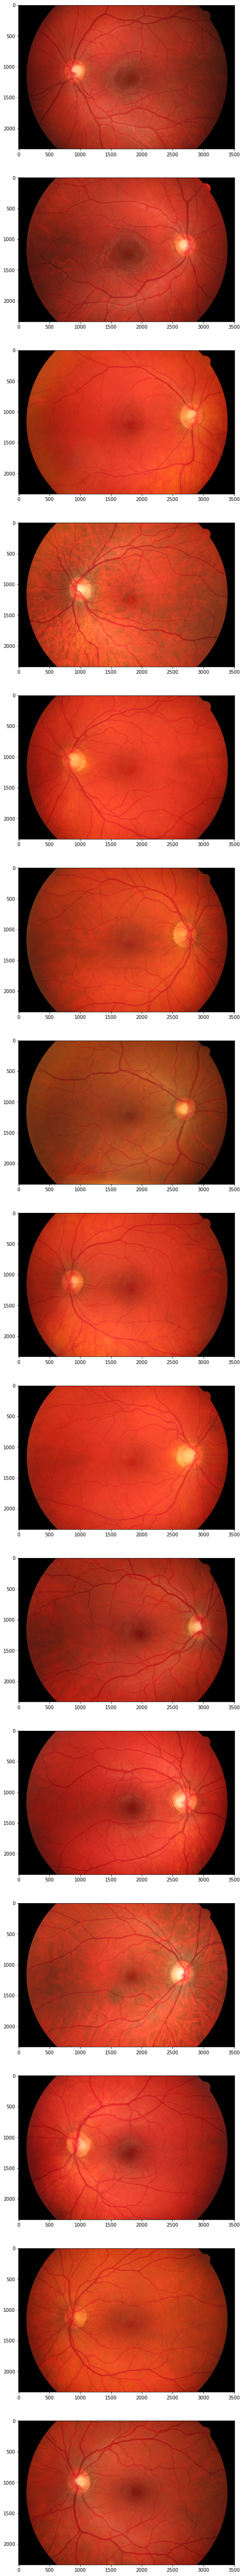

In [2]:
# Loading healthy eye data

size = len(glob.glob('./healthy/*'))
shape = np.array(cv2.imread(glob.glob('healthy/*')[0])).shape
eye_data_type = cv2.cvtColor(cv2.imread(glob.glob('./healthy/*')[0]), cv2.COLOR_BGR2RGB).dtype
mask_data_type = cv2.imread(glob.glob('./healthy_fovmask/*')[0]).dtype

healthy_eye = np.empty(shape=(size, shape[0], shape[1], shape[2]), dtype=eye_data_type)
mask_eye = np.empty(shape=(size, shape[0], shape[1], shape[2]), dtype=mask_data_type)

_, img = plt.subplots(size, figsize=(200,100))

for i, eye in enumerate(glob.glob('./healthy/*')):
    healthy_eye[i] = np.array(cv2.cvtColor(cv2.imread(eye), cv2.COLOR_BGR2RGB))
    img[i].imshow(healthy_eye[i])

for i, mask in enumerate(glob.glob('./healthy_fovmask/*')):
    mask_eye[i] = np.array(cv2.imread(mask))

## 3.2 Segmentation de vaisseaux par méthode conventionnelle

### 1. Implémenter un filtre de "vesselness" comme décrit dans [6]. Vous pouvez vous aider de ressource que vous trouverez sur le web.

### Explanation

Taylor series allow to apporimate a function locally using a series of functions
- We can see a gray scale image as 3D plane :

![](https://i.imgur.com/W83hN6o.png)
- Using Taylor expansion of varying degree we can approximate a point and it's neighbourds :

![](https://i.imgur.com/0pkJJ9c.png)
- Using a serie of derivative :
![](https://i.imgur.com/VjlApHY.png)
- We can define the differentiation as a convolution with derivatives of Gaussians
![](https://i.imgur.com/EEbojUc.png)
- This derivative of a gaussian allows us to select spherical objets :
![](https://i.imgur.com/8tusBgq.png)
- Based on the parameter of the gaussian we can detect object at differents scales :
![](https://i.imgur.com/Bhyd9UU.png)
- It can also be used to measures the contrast between the regions inside and outside the range (-s,s)
![](https://i.imgur.com/XsVuOlo.png)

Using the eigenvalue analysis of the Hessian we can extract the principal directions smallest curvature (along the vessel). The goal is to thus detect small structures going in a single direction.

We can analyse the value following this chart :

![](https://i.imgur.com/jGyRP7e.png)

(we are only interested by the 2D case)

La librairie Scikit-image implémente un filtre de "vesselness".
Nous utilisons donc la fonction: `skimage.filters.frangi`.

In [3]:
from skimage import color
from skimage.filters import frangi
from skimage.morphology import binary_erosion, disk

def vesselness_filter(image: np.ndarray,
                      mask: np.ndarray,
                      **kwargs) -> np.ndarray:
    """
    Filter the vessel in the input image with a vesselness filter.
    The implementation of the vesselness filter used is the scikit-image
    implementation `skimage.filters.frangi`
    Returns a grayscale image with the vessels in the whites
    and the background in the blacks

    Parameters
    ----------
    image: np.ndarray
        2D input grayscale (height, width) or RGB (height, width, 3)
        image of the eyes
    mask: np.ndarray
        2D (boolean) mask of the region of interest of the eyes
        (height, width) or (height, width, 3) according to the input
        True: eye area
        False: backgroud area

    Returns
    -------
    segmented: np.ndarray
        2D Image containing the vessel segmented.
        (height, width)
    """
    assert mask.shape == image.shape

    if image.ndim == 3 and image.shape[-1] == 3: # rgb
        gray_image = color.rgb2gray(image)
        mask = mask[..., 0] | mask[..., 1] |  mask[..., 2]
    elif image.ndim == 2:
        gray_image = image
    else:
        raise ValueError("Wrong input dimension. Expected grayscale or RGB image.")

    if mask.dtype != bool:
        mask = mask.astype(bool)

    if gray_image.dtype == np.uint8:
        gray_image /= 255.

    segmented = frangi(gray_image, **kwargs)

    mask = binary_erosion(mask, disk(5))
    segmented[~mask] = 0.
    return segmented

### 2. Régler (manuellement ou non) les échelles du filtre de vesselness pour que sa réponse soit optimale pour les images de la base de données [1].

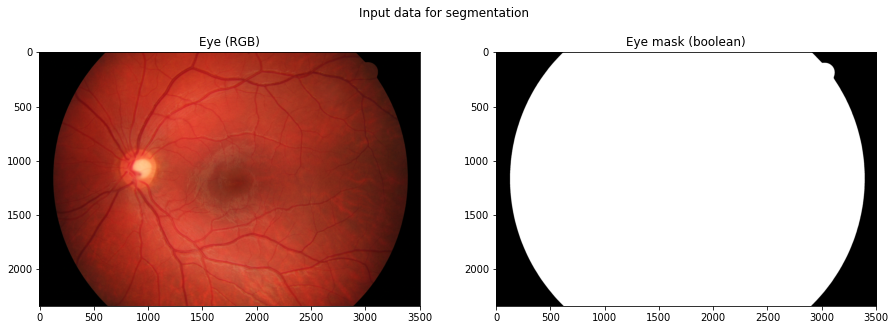

In [4]:
test_image = healthy_eye[0]
test_mask = mask_eye[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Input data for segmentation")
ax[0].set_title("Eye (RGB)")
ax[0].imshow(test_image)
ax[1].set_title("Eye mask (boolean)")
ax[1].imshow(test_mask)
plt.show()

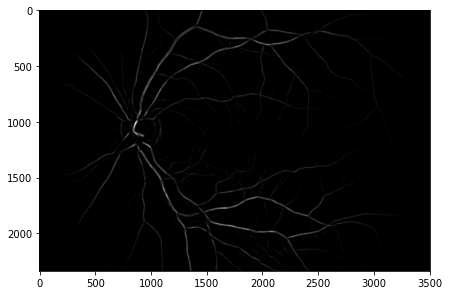

In [5]:
plt.figure(figsize=(7, 5))
plt.imshow(vesselness_filter(test_image, test_mask), cmap='gray')
plt.show()

**Commentaires**:
* Les paramètres sont ajustés automatiquement par la bibliothèque skimage et ils sont adaptés à la base de donnée que nous utilisons.

### 3. Définir une procédure de seuillage pour avoir le meilleur résultat sur la base de données [1].

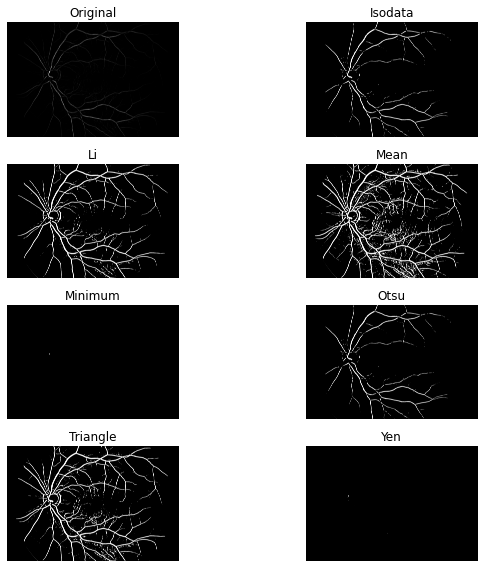

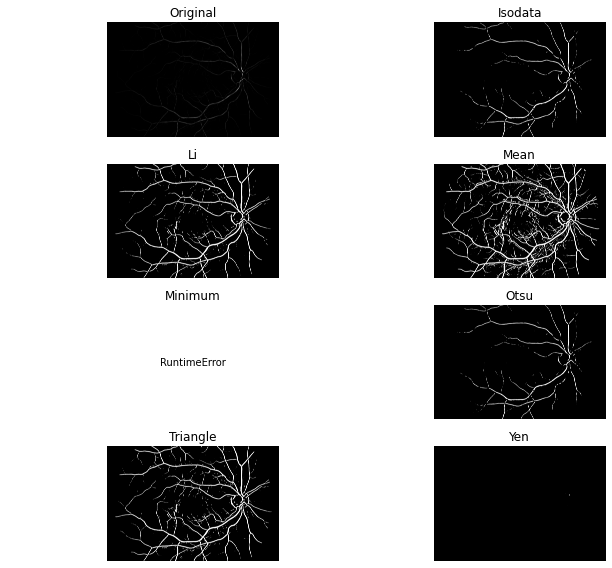

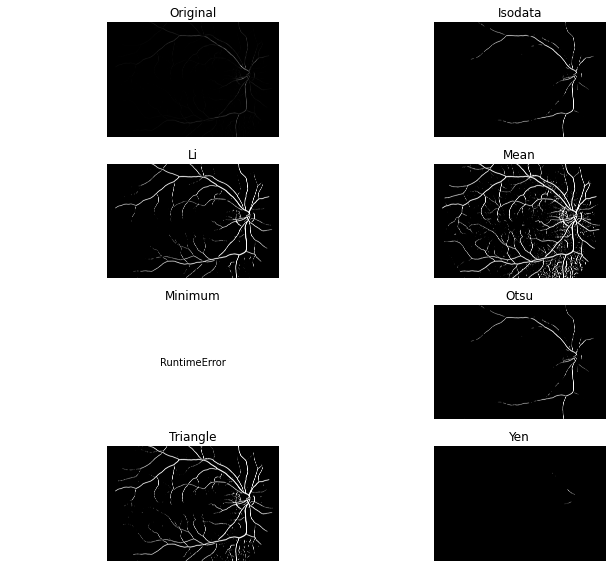

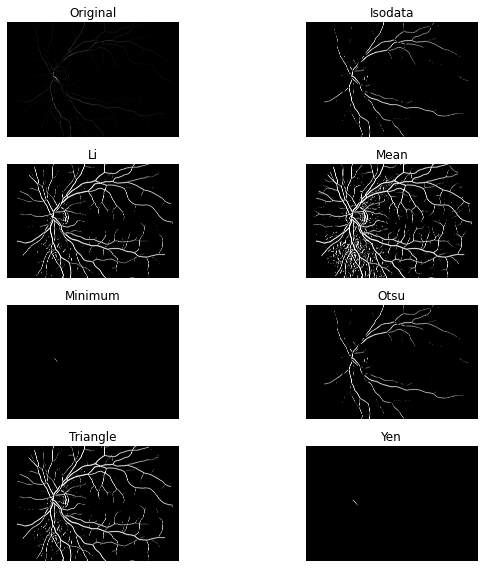

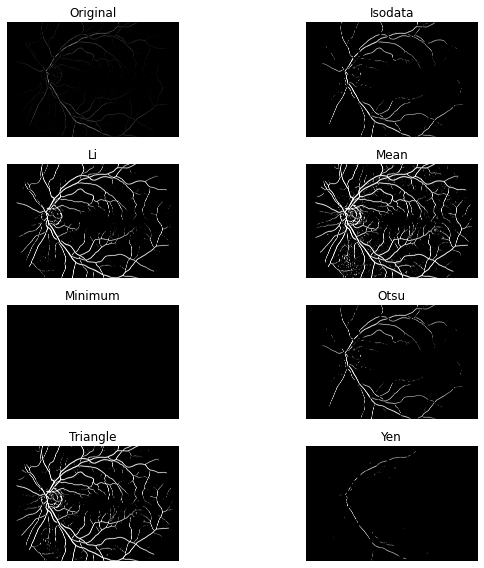

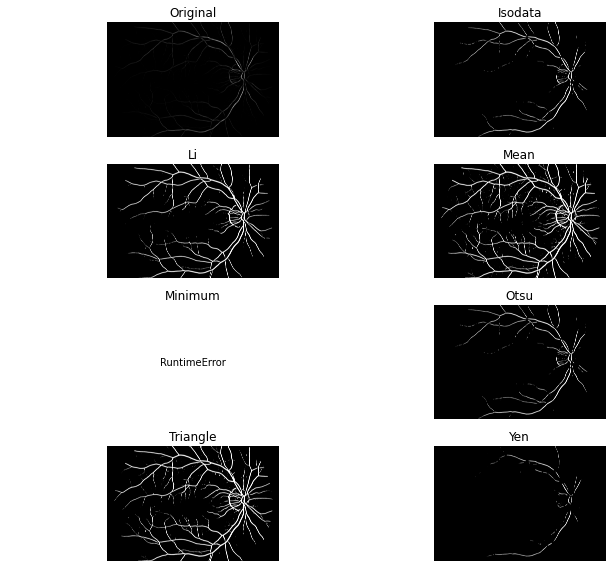

In [6]:
from skimage.filters import try_all_threshold

# Essayons sur 6 images differentes
for i in range(6):
    segmented = vesselness_filter(healthy_eye[i], mask_eye[i])
    fig, ax = try_all_threshold(segmented, figsize=(10, 8), verbose=False)
    plt.show()

Visuellement, le filtre Li nous paraît le plus pertinent pour segmenter les vaisseaux sanguins.

In [7]:
from skimage.filters import threshold_li

def segment_vessels(image: np.ndarray,
                    mask: np.ndarray,
                    **kwargs) -> np.ndarray:
    """
    Segment the vessel in the input image with a vesselness filter and a Li filter.
    The implementation of the vesselness filter used is the scikit-image
    implementation `skimage.filters.frangi`
    The implementation of the Li filter used is the scikit-image implementation
    `threshold_li`
    Returns a boolean image with the vessels as True and the rest as False

    Parameters
    ----------
    image: np.ndarray
        2D input grayscale (height, width) or RGB (height, width, 3)
        image of the eyes
    mask: np.ndarray
        2D (boolean) mask of the region of interest of the eyes
        (height, width) or (height, width, 3) according to the input
        True: eye area
        False: backgroud area

    Returns
    -------
    segmented: np.ndarray
        2D Image (boolean) containing the vessel segmented thresholded.
        (height, width)
    """
    segmented = vesselness_filter(image, mask, **kwargs)
    th = threshold_li(segmented)
    return segmented > th

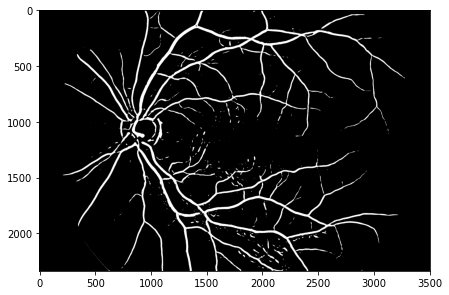

In [8]:
plt.figure(figsize=(7, 5))
test_vessels = segment_vessels(test_image, test_mask)
plt.imshow(test_vessels, cmap="gray")

## 3.3 Segmentation de lignes centrales

### 1. A partir d’une image segmentée provenant de [1], extraire un ensemble de lignes centrales correspondant à ces structures segmentées.

In [9]:
from skimage.morphology import skeletonize, binary_dilation

def extract_central_lines(seg):
    """
    Extract central lines from segmented image
    Use the morphology functions from scikit-image
    
    Steps:
    1. Skeletonize the vessels
    2. Apply dilation to remove small skeletons artefacts and unrelevant intersections
    3. Re-skeletonize
    
    Parameters
    ----------
    seg: np.ndarray
        2D Image (boolean) vessels segmented image (height, width)

    Returns
    -------
    skel: np.ndarray
        2D Image (boolean) containing the central lines
        (height, width)
    """
    skel = skeletonize(seg).astype(np.uint16)
    skel = binary_dilation(skel, disk(25))
    skel = skeletonize(skel)
    return skel

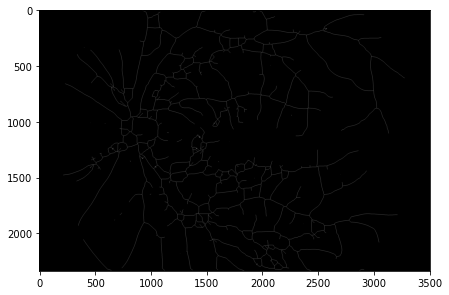

In [10]:
test_vessels_skel = extract_central_lines(test_vessels)

plt.figure(figsize=(7, 5))
plt.imshow(test_vessels_skel, cmap="gray")

### 2. En vous aidant de [3], représenter ces lignes centrales par un graph de lignes centrales connectées entre-elles.

In [11]:
import sknw

graph = sknw.build_sknw(test_vessels_skel)

### 3. Appliquer les deux étapes précédentes à la sortie de votre segmentation de vaisseaux par filtre "vesselness et seuillage". Quels sont les défauts que vous observez ?

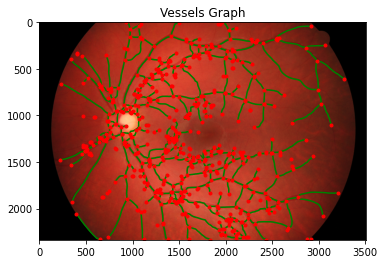

In [12]:
def plot_vessels_graph(input_image: np.ndarray,
                       graph,
                       ax=None,
                       title:str=None) -> None:
    """
    Parameters
    ----------
    image: np.ndarray
        2D input grayscale (height, width) or RGB (height, width, 3)
        image of the eyes
    graph: networkx.classes.graph.Graph
        Graph of the vessels in the input eyes
    """
    local_plt = plt
    if ax is not None:
        local_plt = ax
        
    local_plt.imshow(input_image, cmap='gray')

    for (s,e) in graph.edges():
        ps = graph[s][e]['pts']
        local_plt.plot(ps[:,1], ps[:,0], 'green')

    nodes = graph.nodes()
    ps = np.array([nodes[i]['o'] for i in nodes])
    local_plt.plot(ps[:,1], ps[:,0], 'r.')

    if title is None:
        title = "Vessels Graph"
        
    if ax is not None:
        ax.set_title(title)
    else:
        plt.title(title)


plot_vessels_graph(test_image, graph)

Le défaut apparent est qu'il y a beaucoup trop d'intersections détectées. Nous pourrions utiliser une méthode en post-traitement pour supprimer les intersections détéctées qui sont trop proches.

## Function pour calculer le graphe des vaisseaux (sum up function)

In [13]:
def compute_vessels_graph(image: np.ndarray,
                          mask: np.ndarray,
                          plot: bool=False,
                          **kwargs) -> np.ndarray:
    """
    Filter and segmented the vessel in the input image.
    Then, compute graph of the vessels 
    

    Parameters
    ----------
    image: np.ndarray
        2D input grayscale (height, width) or RGB (height, width, 3)
        image of the eyes
    mask: np.ndarray
        2D (boolean) mask of the region of interest of the eyes
        (height, width) or (height, width, 3) according to the input
        True: eye area
        False: backgroud area
    plot: boolean
        Whether to plot intermediate steps

    Returns
    -------
    graph: networkx.classes.graph.Graph
        Graph of the vessels in the input eyes
    """
    # Segment vessels
    seg = segment_vessels(image, mask, **kwargs)
    # Skeletonize vessels
    skel = extract_central_lines(seg)
    # Compute graph of the skeleton
    graph = sknw.build_sknw(skel)
    
    if plot is True:
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Input eyes")
        ax[1].imshow(seg, cmap="gray")
        ax[1].set_title("Vessels segmentation")
        ax[2].imshow(skel, cmap="gray")
        ax[2].set_title("Vessels skeleton")
        plot_vessels_graph(image, graph, ax[3])
    
    return graph

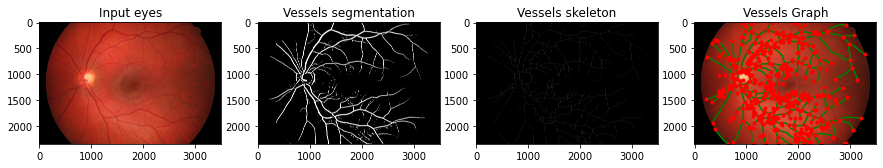

In [14]:
graph = compute_vessels_graph(test_image, test_mask, plot=True)